In [1]:
from PIL.ExifTags import TAGS
import pathlib
import csv
import glob
from PIL import Image
import pandas as pd
import os
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
from scipy.optimize import curve_fit
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
from skimage.color import rgb2gray
import os
import re
import math
import matplotlib.ticker as tck
import argparse
import cv2
import skimage as ski


Reading data

In [9]:
path = 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1'
Exp1 = pd.read_csv(path +'/data_exp1.csv', index_col=None)
Exp1 = Exp1.drop(columns=['Unnamed: 0'])

print(Exp1)


           id  id_in_image                                   path  \
0           1            1  E:/instru_projects/TimeSeriesAnalysis   
1           2            1  E:/instru_projects/TimeSeriesAnalysis   
2           3            1  E:/instru_projects/TimeSeriesAnalysis   
3           4            1  E:/instru_projects/TimeSeriesAnalysis   
4           5            1  E:/instru_projects/TimeSeriesAnalysis   
...       ...          ...                                    ...   
181739  10782            1  E:/instru_projects/TimeSeriesAnalysis   
181740  10783            1  E:/instru_projects/TimeSeriesAnalysis   
181741  10784            1  E:/instru_projects/TimeSeriesAnalysis   
181742  10785            1  E:/instru_projects/TimeSeriesAnalysis   
181743  10786            1  E:/instru_projects/TimeSeriesAnalysis   

          well_type  seeding_density    date cell_line  cell_line_no  \
0             ibidi             2500  210821    MCF10A             1   
1             ibidi        

Normalizing by first value

In [12]:
Exp1_grouped = Exp1.groupby(['date', 'cell_line', 'material'])

#get the first incubation timestamps for each group
min_Exp1 = Exp1_grouped['incubation_time'].agg('min').reset_index()

#filter them out
Exp1_allmin = Exp1.merge(min_Exp1, on=['date', 'cell_line', 'material', 'incubation_time'])

#columns to normalize
columns = ['area', 'perimeter', 'convex hull area', 'convex hull perimeter',
           'convexity_perimeter', 'convexity_area', 'compactness', 'aspect_ratio']

# Step 3: Group by the desired columns and calculate averages
Exp1_min_averages = Exp1_allmin.groupby(['date', 'cell_line', 'material']).agg({column: 'mean' for column in columns}).rename(columns={column: f"{column}_first" for column in columns}).reset_index()

Exp1_N = Exp1.merge(Exp1_min_averages, on=['date', 'cell_line', 'material'])


for column in columns:
    Exp1_N[f'{column}_N'] = Exp1_N[column] / Exp1_N[f'{column}_first']

print(Exp1_N)

saving_path= 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1'
Exp1_N.to_csv(saving_path+'/Exp1_N.csv')  


           id  id_in_image                                   path  \
0           1            1  E:/instru_projects/TimeSeriesAnalysis   
1           2            1  E:/instru_projects/TimeSeriesAnalysis   
2           3            1  E:/instru_projects/TimeSeriesAnalysis   
3           4            1  E:/instru_projects/TimeSeriesAnalysis   
4           5            1  E:/instru_projects/TimeSeriesAnalysis   
...       ...          ...                                    ...   
181739  10782            1  E:/instru_projects/TimeSeriesAnalysis   
181740  10783            1  E:/instru_projects/TimeSeriesAnalysis   
181741  10784            1  E:/instru_projects/TimeSeriesAnalysis   
181742  10785            1  E:/instru_projects/TimeSeriesAnalysis   
181743  10786            1  E:/instru_projects/TimeSeriesAnalysis   

          well_type  seeding_density    date cell_line  cell_line_no  \
0             ibidi             2500  210821    MCF10A             1   
1             ibidi        

In [13]:
Exp1_N['cell_line'] = np.where(Exp1_N['cell_line'].str.contains('DCIS', na=False), 'MCF10DCIS.com', Exp1_N['cell_line'])
unique_materials = Exp1_N['material'].unique()
unique_lines = Exp1_N['cell_line'].unique()
unique_materials[2],unique_materials[3]=unique_materials[3],unique_materials[2]
print(unique_materials)
print(unique_lines)

['collagen 2mg/ml' 'IPN 2.5mM' 'IPN 22mM' 'IPN 40mM']
['MCF10A' 'MCF10DCIS.com' 'MCF10AT']


In [8]:
#print(Exp1.head)

for i,unique_material in enumerate(unique_materials):
    specific_df = Exp1[(Exp1['material'] == unique_material)]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]
        unique_times = specific_specific_df['incubation_time'].unique()
        for k,unique_time in enumerate(unique_times):
            specific_specific_specific_df = specific_specific_df[(specific_specific_df['incubation_time'] == unique_time)]
            print(unique_material, unique_line, 'incubation time:',unique_time,'number of pictures:', len(specific_specific_specific_df['path'].unique()))
        break   


collagen 2mg/ml MCF10A incubation time: 120 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 144 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 168 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 72 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 96 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 192 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 24 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 48 number of pictures: 1
collagen 2mg/ml MCF10A incubation time: 216 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 120 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 144 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 168 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 192 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 240 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 96 number of pictures: 1
IPN 2.5mM MCF10A incubation time: 24 number of pict

In [18]:
color=['red','blue','green']


palette = {
    'MCF10A': 'tab:red',
    'MCF10DCIS.COM': 'tab:blue',
    'MCF10AT': 'tab:green',
}

lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in color]
labels = ['MCF10A', 'MCF10DCIS.COM', 'MCF10AT']


Time-series of the mean of spheroid areas for each cell line & material

TypeError: agg function failed [how->mean,dtype->object]

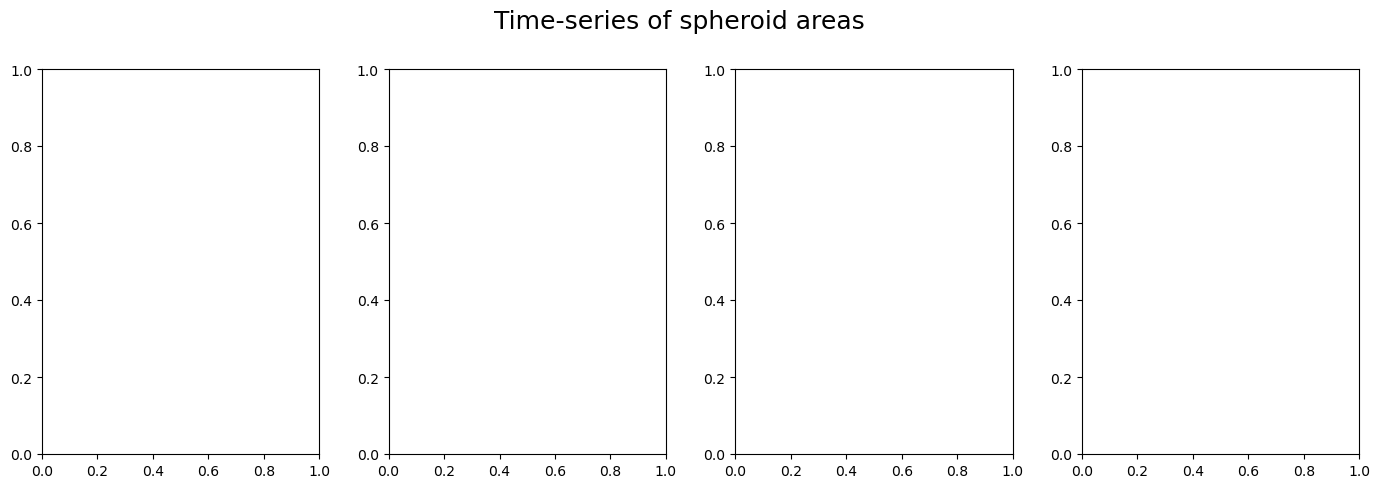

In [14]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17,5))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.suptitle("Time-series of spheroid areas", fontsize=18, y=1)

for i,unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[Exp1_N['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
    #print(specific_df_grp.head())
    ax=axs[i]
    ax.plot(specific_df_grp.unstack(0)['area']) # area as a function of incubation time, for each cell line
    ax.set_xlabel('Incubation Time [h]')  
    ax.set_ylabel('Mean Area')        
    ax.set_title(unique_material)


C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\286684497.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(specific_specific_df, x='area',ax=ax, hue='incubation_time', log_scale=True)


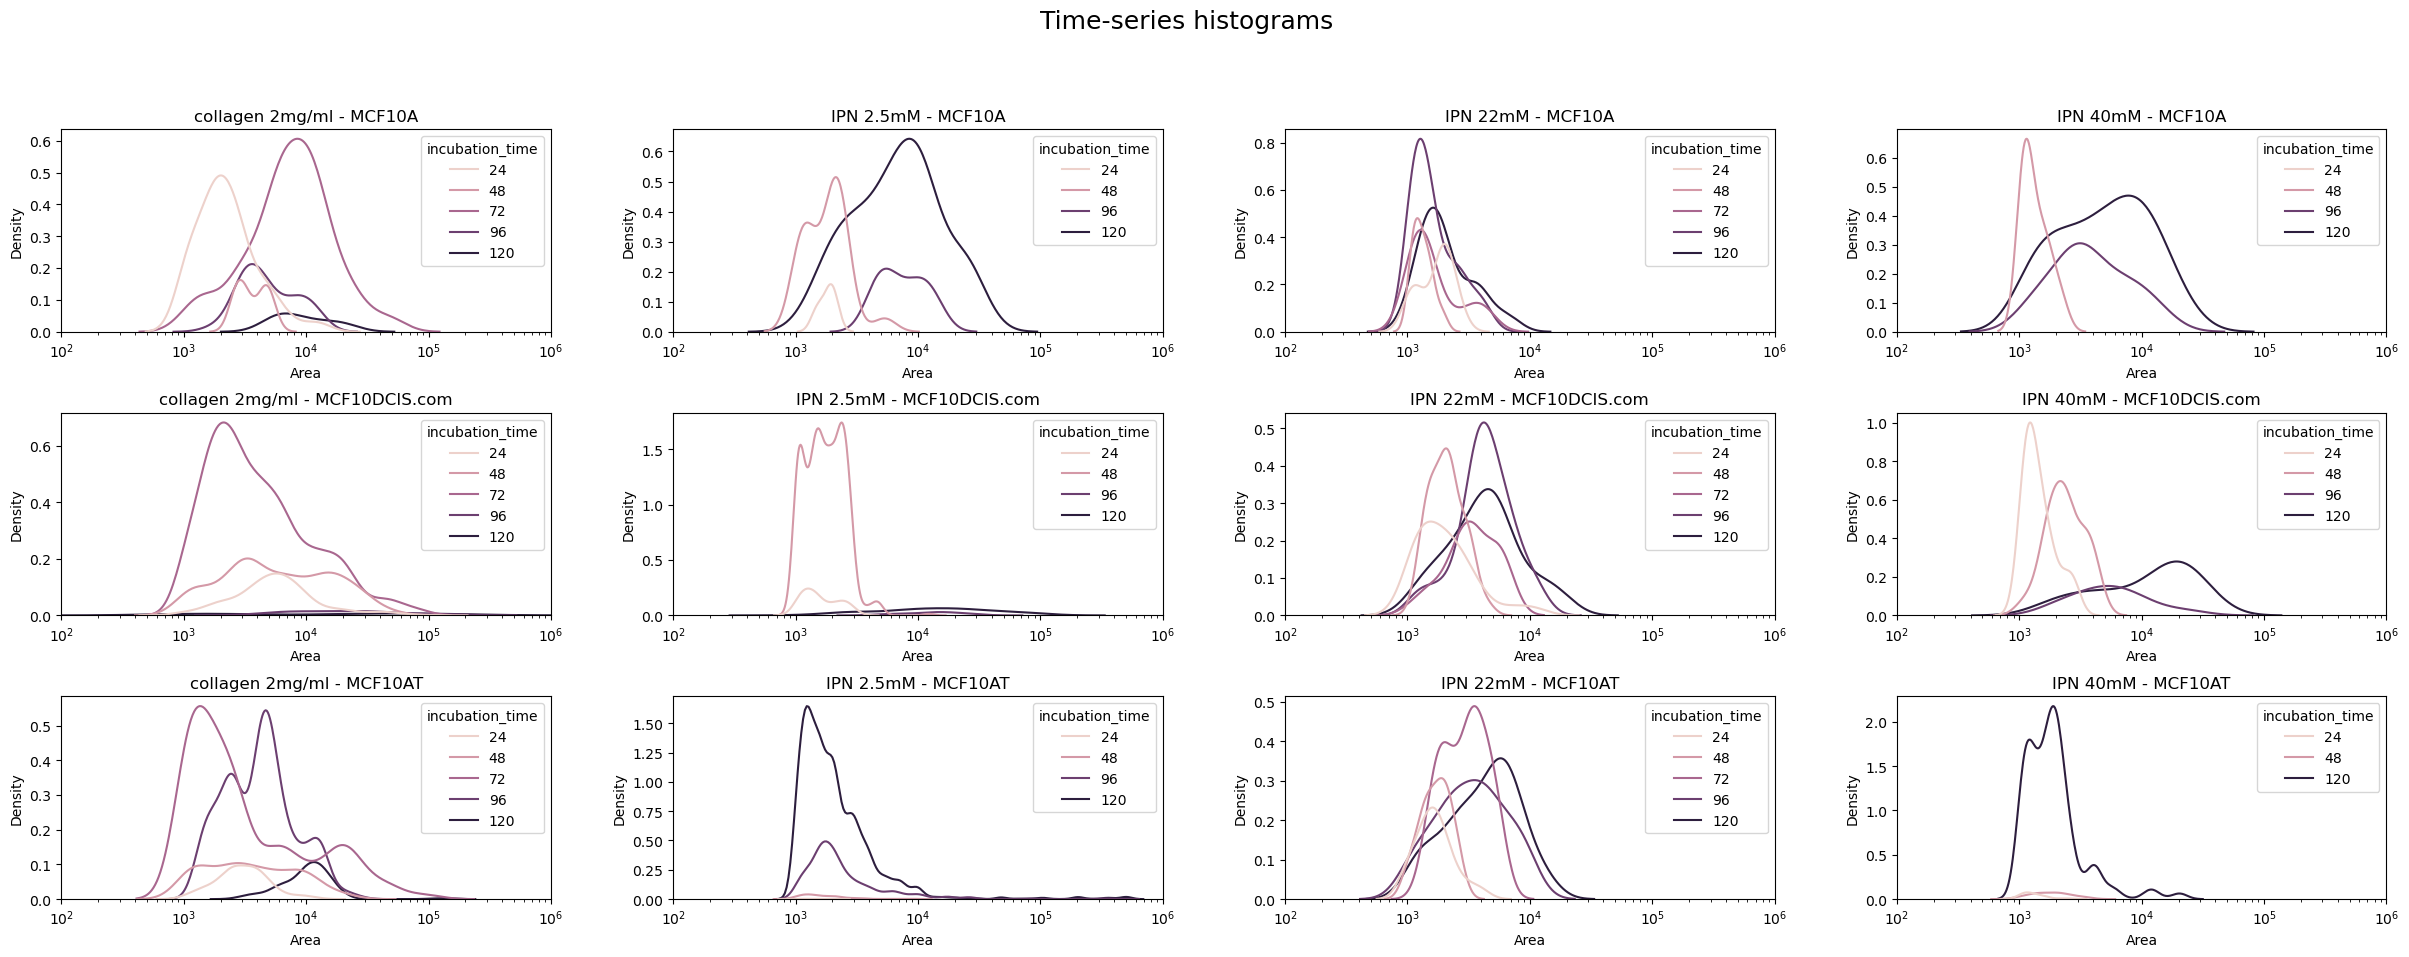

In [15]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Time-series histograms", fontsize=18, y=1)

timestamp = 140     #DEFINE
cuttof_area = 1000  #DEFINE

for i,unique_material in enumerate(unique_materials):
    specific_df = Exp1_N[(Exp1_N['material'] == unique_material) & (Exp1_N['area'] > cuttof_area) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line) & (specific_df['incubation_time'] < timestamp)]
        ax=axs[j,i]
        sns.kdeplot(specific_specific_df, x='area',ax=ax, hue='incubation_time', log_scale=True)
        ax.set_xlabel('Area')  
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_xlim(100,1000000)
        #ax.set_ylim(0,0.6)

In [121]:
Exp1.columns

Index(['Unnamed: 0', 'id', 'id_in_image', 'path', 'well_type',
       'seeding_density', 'date', 'cell_line', 'cell_line_no',
       'incubation_time', 'image_id', 'magnification', 'material',
       'concentration', 'area', 'perimeter', 'convex hull area',
       'convex hull perimeter', 'convexity_perimeter', 'convexity_area',
       'compactness', 'aspect_ratio', 'area_first_x', 'perimeter_first_x',
       'convex hull area_first_x', 'convex hull perimeter_first_x',
       'convexity_perimeter_first_x', 'convexity_area_first_x',
       'compactness_first_x', 'aspect_ratio_first_x', 'area_N', 'perimeter_N',
       'convex hull area_N', 'convex hull perimeter_N',
       'convexity_perimeter_N', 'convexity_area_N', 'compactness_N',
       'aspect_ratio_N', 'area_first_y', 'perimeter_first_y',
       'convex hull area_first_y', 'convex hull perimeter_first_y',
       'convexity_perimeter_first_y', 'convexity_area_first_y',
       'compactness_first_y', 'aspect_ratio_first_y'],
      dty

In [49]:
def looping(data, unique_materials, unique_lines, title, function,variable,xlim, ylim):
    
    fig.suptitle(title, fontsize=18, y=0.95)

    for i, unique_material in enumerate(unique_materials):
        specific_data = data[data['material'] == unique_material]
        for j, unique_line in enumerate(unique_lines):
            specific_specific_data = specific_data[specific_data['cell_line'] == unique_line]
            
            function(specific_specific_data, i, j, unique_material, unique_line,variable,xlim, ylim)

Realtive area

In [78]:
def plotting(data ,i, j, unique_material, unique_line,variable,xlim,ylim):
    ax = axs[j,i]
    sns.stripplot(x='incubation_time', y=variable, data=data, 
               color=color[j], label=unique_line, ax=ax, jitter=True)
    mean_values = data.groupby('incubation_time')[variable].mean().reset_index()
# Create the mean plot using pointplot
    sns.pointplot(x='incubation_time', y=variable, data=data,
               estimator='mean', color='orange', label='Mean', 
               ax=ax, markers='_', linewidth=2)    
    ax.get_legend().remove()
    ax.set_xlabel('Incubation time [hours]', fontsize=15)  
    #ax.set_yscale('log')
    ax.set_ylabel(variable, fontsize=15)  
    ax.set_title(f'{unique_material}', fontsize=18)
    ax.set_ylim(xlim, ylim)
    #x_ticks = [24,48,72,96,120,144,168,192, 214, 240]
    #ax.set_xticks(x_ticks)  # Set the x-ticks

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)


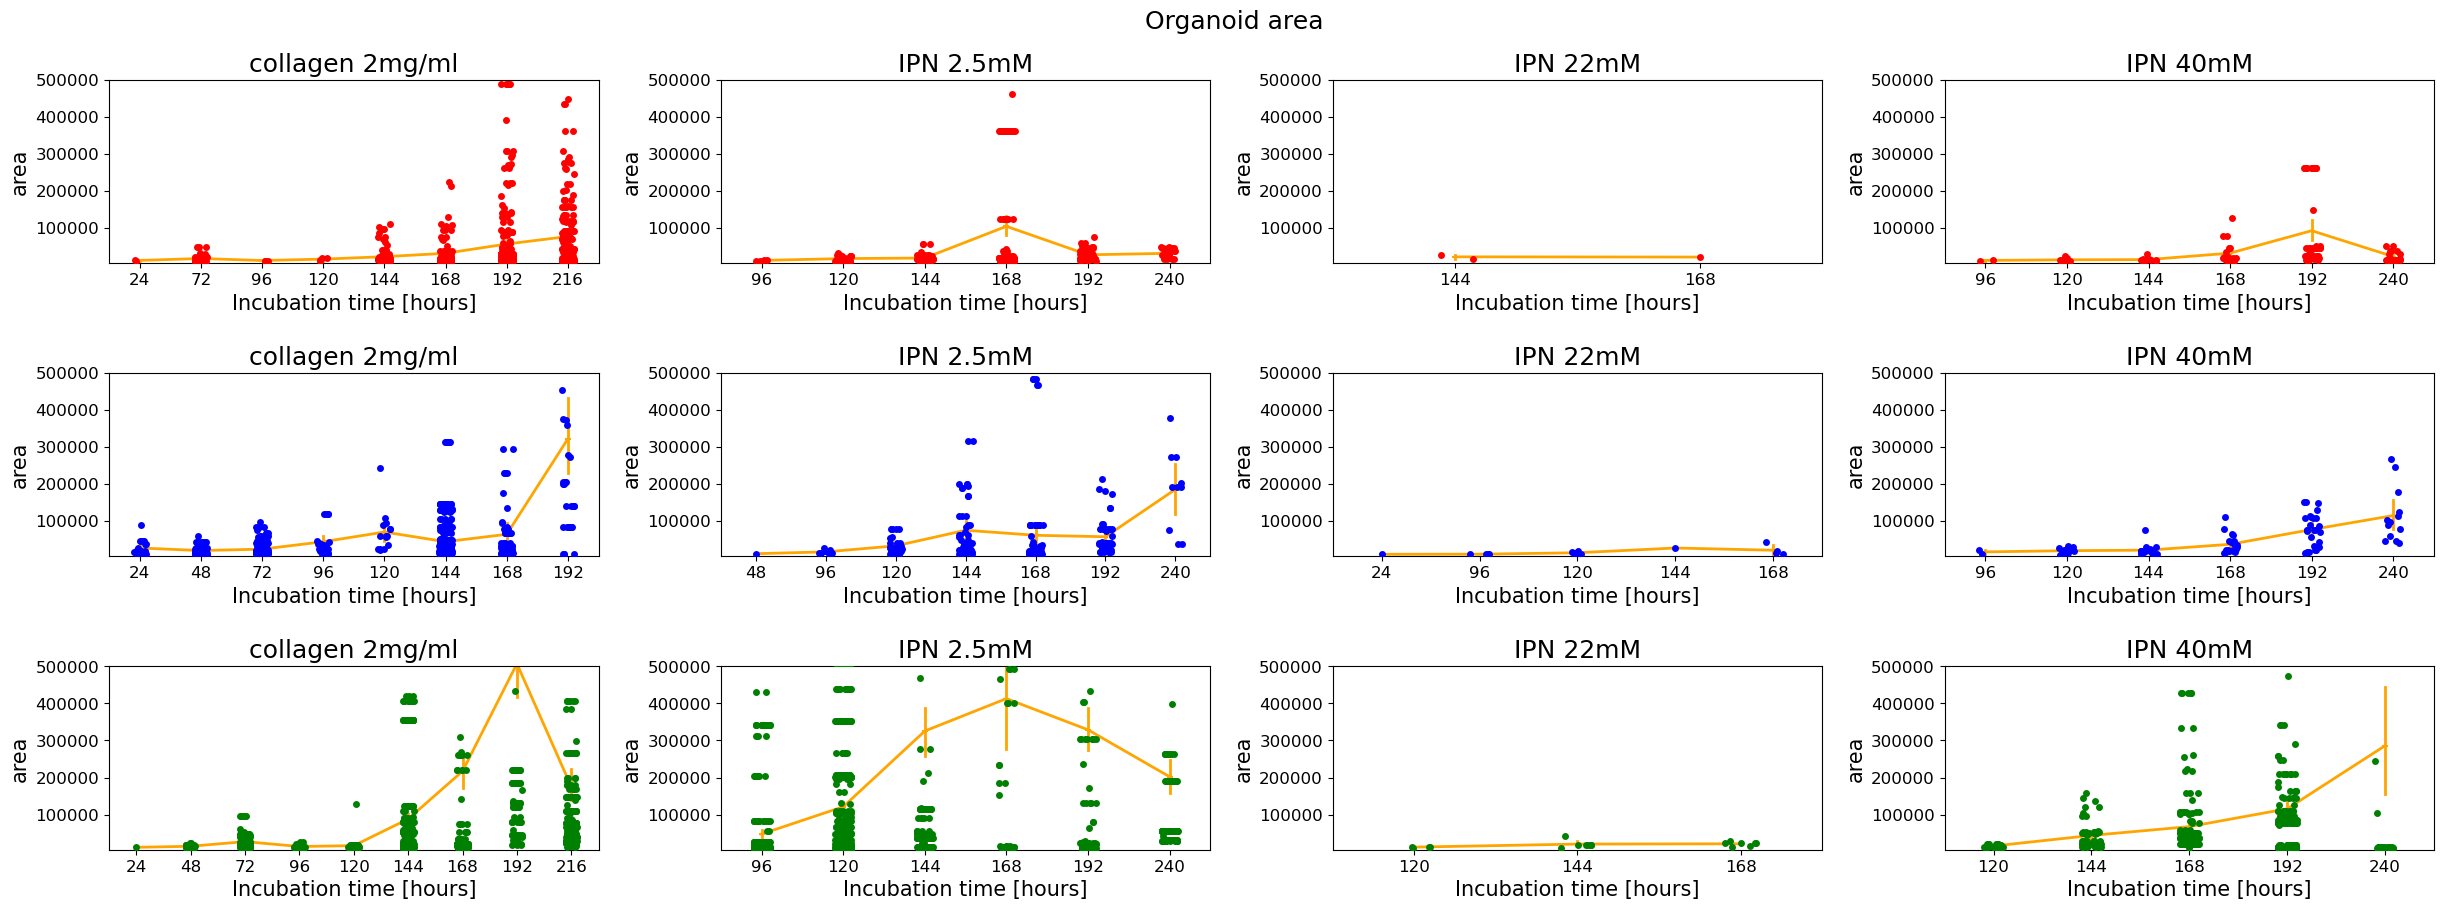

In [79]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Organoid area', plotting, 'area',5000, 500000)
plt.savefig(path +'/results/Organoid_area.png',dpi=300)


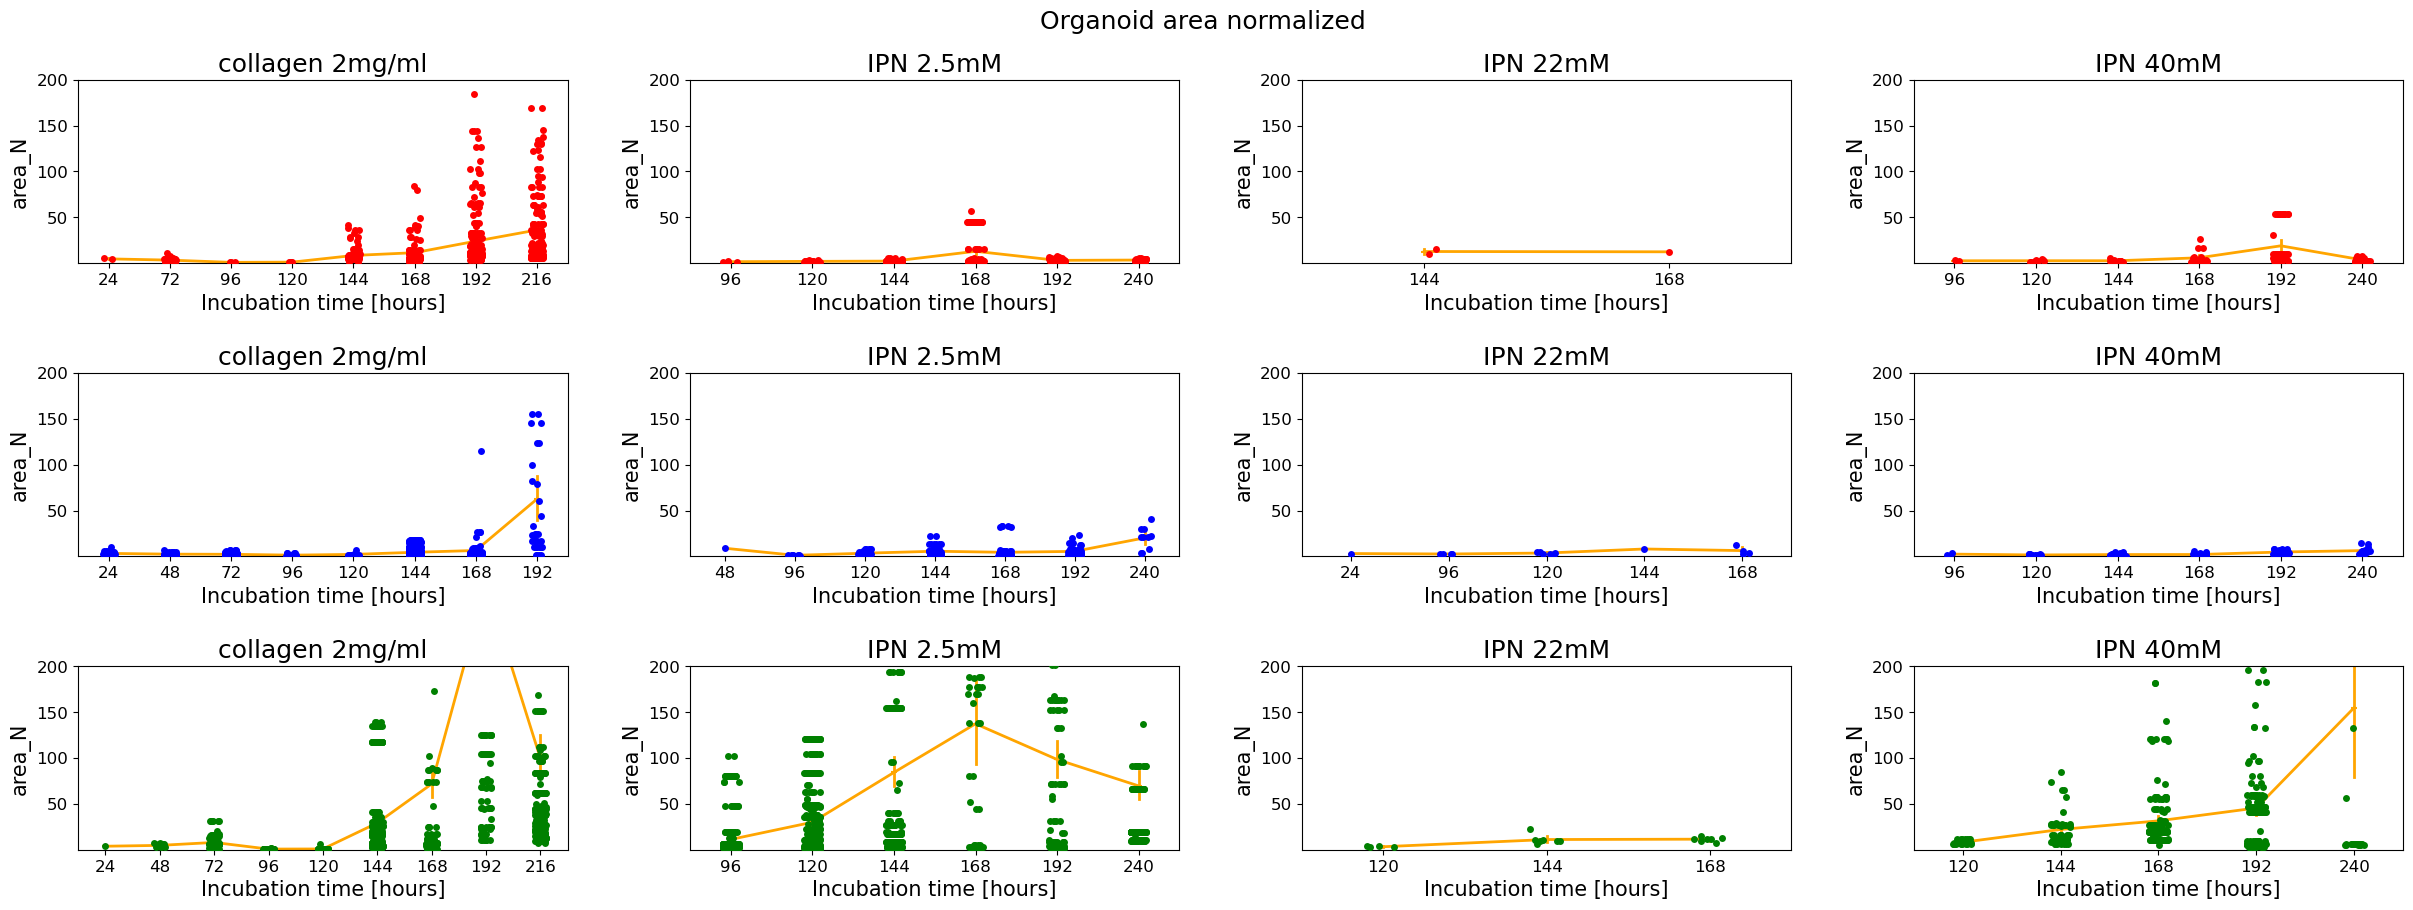

In [85]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Organoid area normalized', plotting, 'area_N',0.01, 200)
plt.savefig(path +'/results/Organoid_area_N.png',dpi=300)

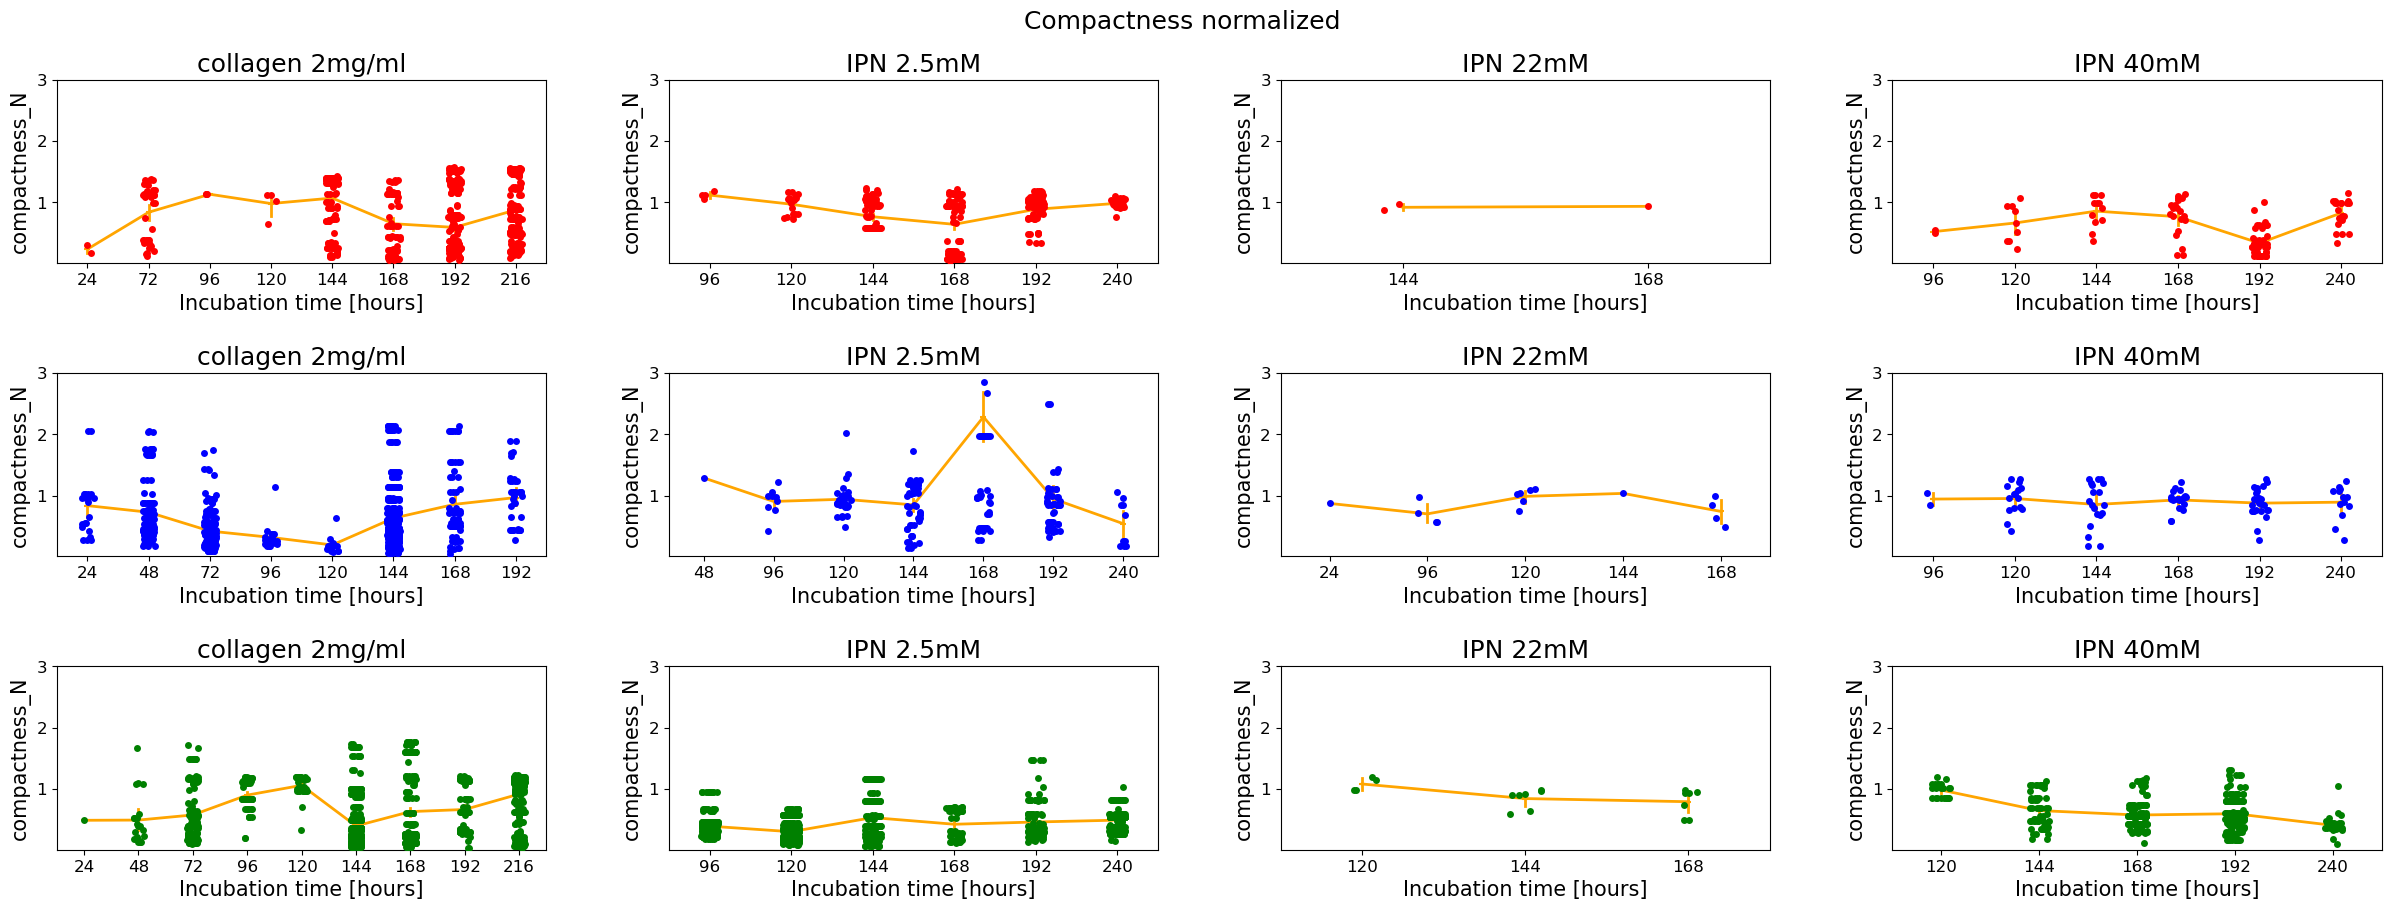

In [87]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Compactness normalized', plotting,'compactness_N',0.01,3)
plt.savefig(path +'/results/Compactness_area_N.png',dpi=300)

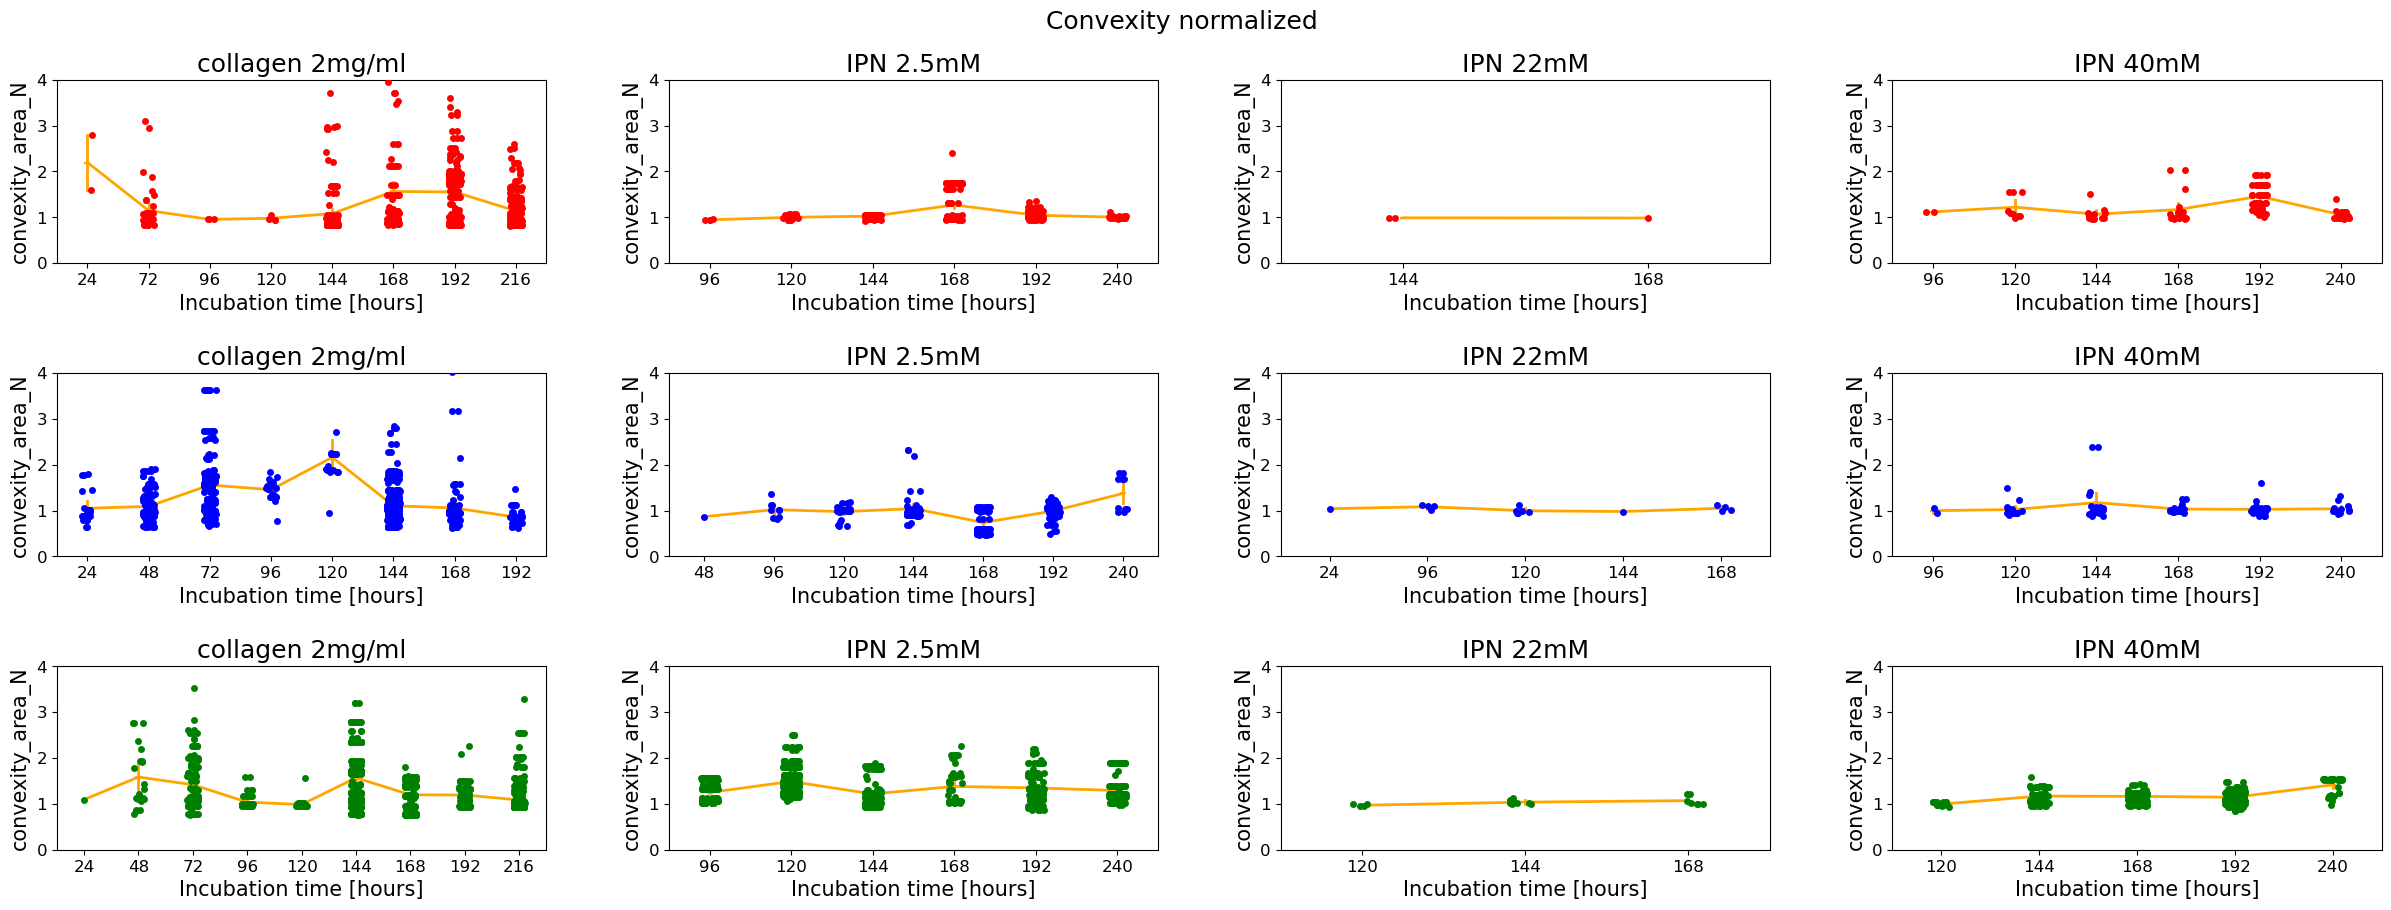

In [90]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Convexity normalized', plotting,'convexity_area_N',0,4)
plt.savefig(path +'/results/Compactness_areaN.png',dpi=300)

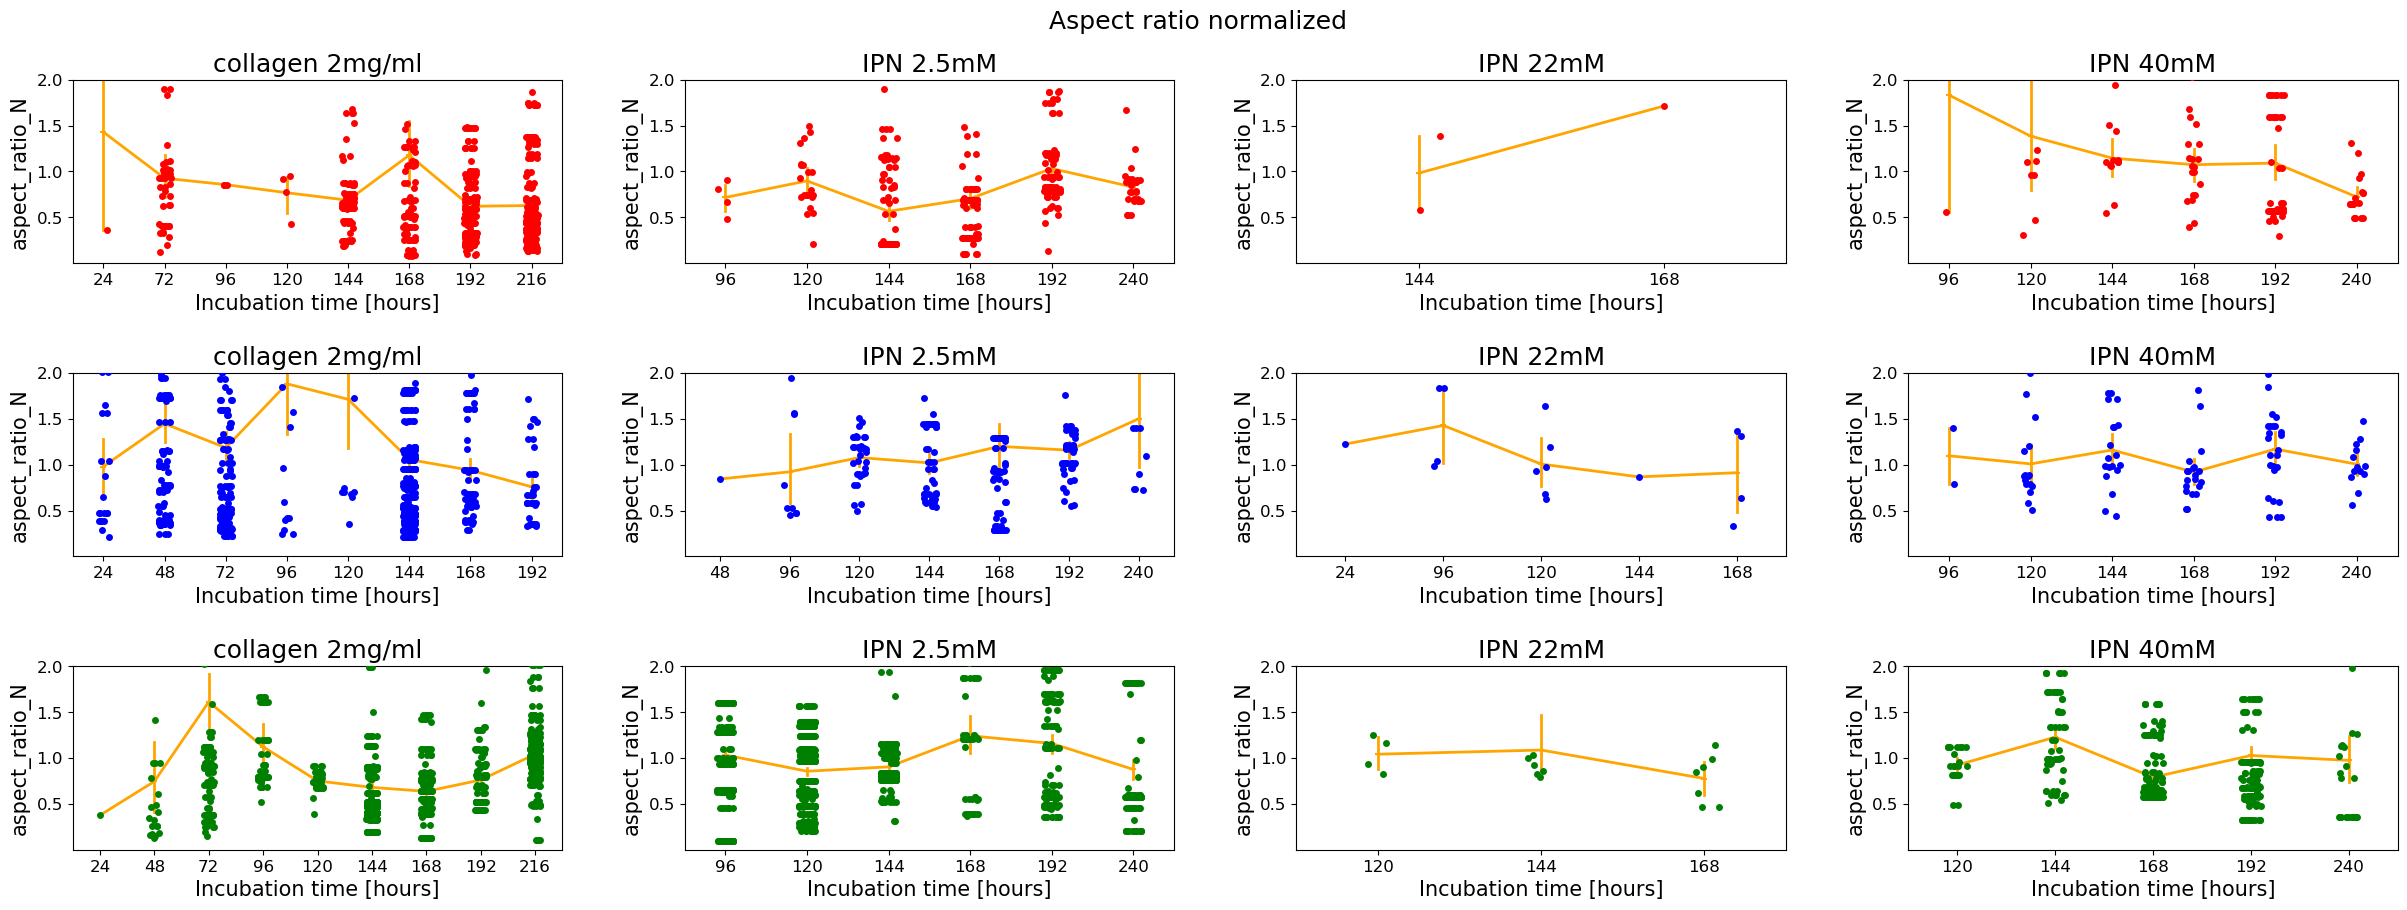

In [93]:
fig, axs = plt.subplots(len(unique_lines), len(unique_materials), figsize=(30, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines, 'Aspect ratio normalized', plotting,'aspect_ratio_N',0.001, 2)
plt.savefig(path +'/results/Compactness_areaN.png',dpi=300)

Fitting models to data

In [92]:
import numpy as np
from scipy.optimize import curve_fit

def gompertz(t, a, b, c):
    """Gompertz function definition."""
    return a * np.exp(-b * np.exp(-c * t))

def gompertz_fit(data, i, j, unique_material, unique_line):
    # Initial guess for parameters [a, b, c]
    a=data['area_N'].max()+1000
    est_par = [a, 0.8, 10]  
    
    # Fit the Gompertz function to the data
    params, covariance = curve_fit(gompertz, data['incubation_time'], data['area_N'], p0=est_par)
    
    # Extract fitted parameters
    a_fit, b_fit, c_fit = params

    # Generate values for the fitted curve
    xrange = np.linspace(data['incubation_time'].min(), data['incubation_time'].max(), 100) 
    fitted_values = gompertz(xrange, a_fit, b_fit, c_fit)   

    # Calculate residuals and standard error
    residuals = data['area'] - gompertz(data['incubation_time'], a_fit, b_fit, c_fit)
    std_error = np.std(residuals)
    
    # Call your plotting function with the fitted values and parameters
    plotting_fits(gompertz, xrange, fitted_values, std_error, i, j, unique_material, unique_line)

def polynomial_fit(data, i, j, unique_material, unique_line):
    # Fit a polynomial (linear in this case)
    mymodel = np.poly1d(np.polyfit(data['incubation_time'], data['area'], 1))
    xrange = np.linspace(data['incubation_time'].min(), data['incubation_time'].max(), 100)
    fitted_values = mymodel(xrange)

    # Calculate residuals and standard error
    residuals = data['area'] - mymodel(data['incubation_time'])
    std_error = np.std(residuals)

    # Call your plotting function
    plotting_fits(mymodel, xrange, fitted_values, std_error, i, j, unique_material, unique_line)

def plotting_fits(model, x_range, fitted_line_values, std_error, i, j, unique_material, unique_line):
    ax = axs[i]
    ax.plot(x_range, fitted_line_values, color=color[j], label=unique_line)  # Use fitted values for plotting
    ax.fill_between(x_range, fitted_line_values - std_error, fitted_line_values + std_error, color=color[j], alpha=0.3)
    ax.set_xlabel('Incubation time [hours]', fontsize=15)  
    ax.set_yscale('log')
    ax.set_ylabel('Area', fontsize=15)  
    ax.set_title(f'{unique_material}', fontsize=18)
    ax.set_ylim(5000, 1000000)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Gompertz pol', gompertz_fit)


C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\5460948.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(gompertz, data['incubation_time'], data['area_N'], p0=est_par)


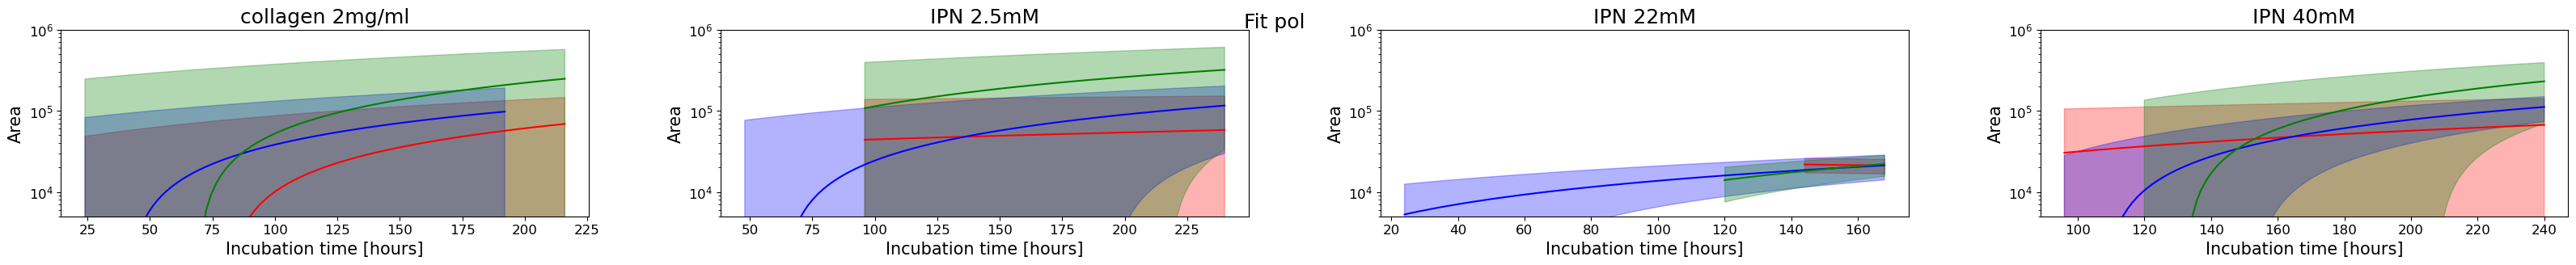

In [76]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(40, 3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Fit", fontsize=20, y=1.1)

looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Fit pol', polynomial_fit)


In [77]:
looping(Exp1_N[(Exp1_N['area'] > 10000)], unique_materials, unique_lines,'Gompertz pol', gompertz_fit)


c:\Users\srboval1\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\3554219881.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(gompertz, data['incubation_time'], data['area'], p0=est_par)
C:\Users\srboval1\AppData\Local\Temp\ipykernel_13980\3554219881.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * np.exp(-c * t))


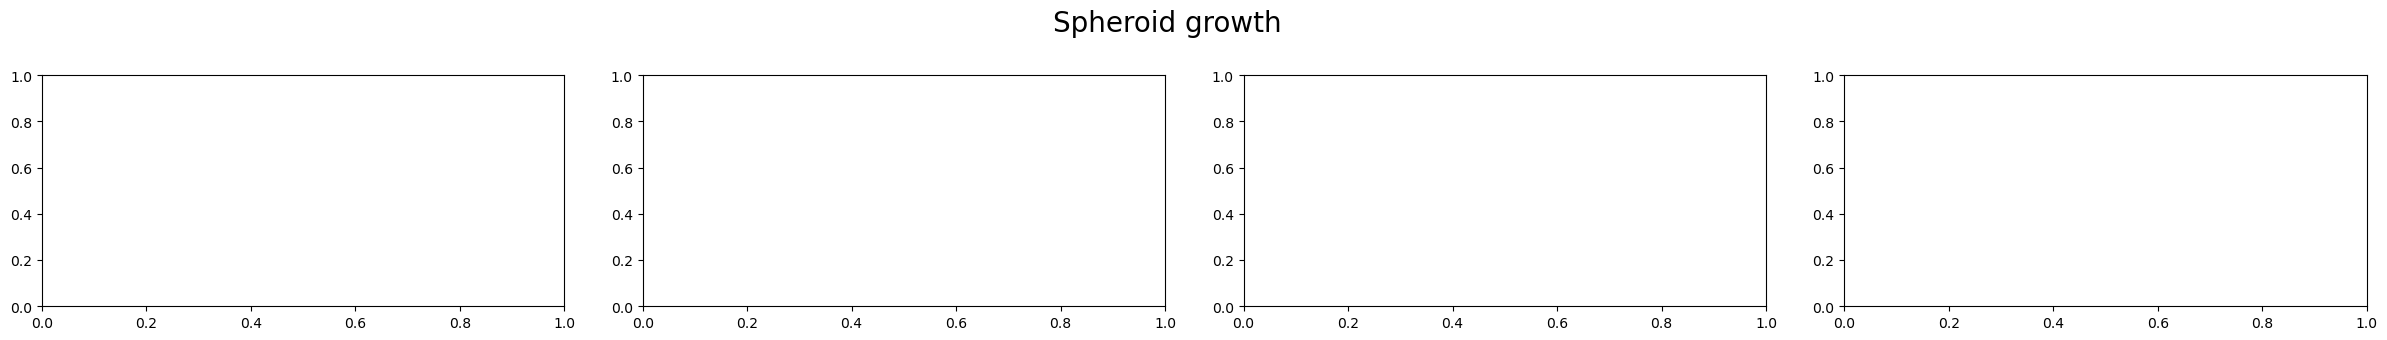

In [78]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Spheroid growth", fontsize=20, y=1.1)


plt.savefig(path +'/results/Spheroid_growth_curve.png',dpi=300)


KDE plot - join distribution time-series

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1/plots/Kernel_density_individual_cells.png'

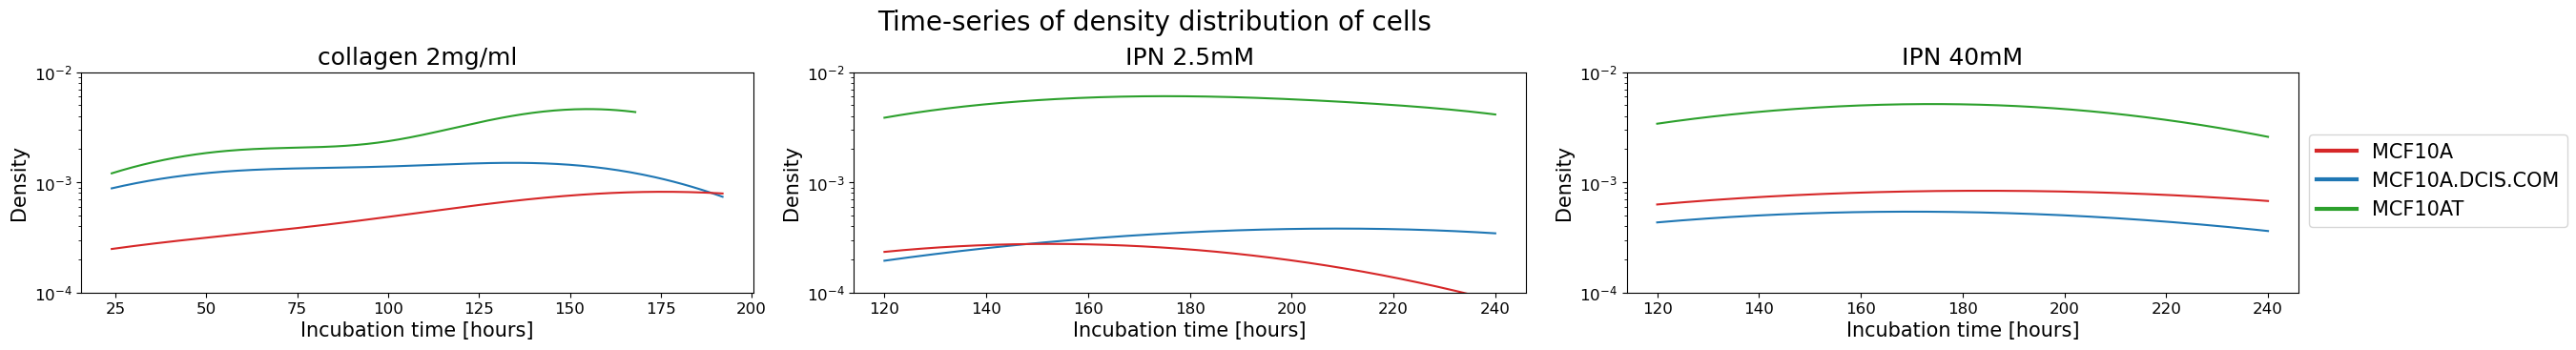

In [55]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Time-series of density distribution of cells", fontsize=20, y=1.1)


for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    ax=axs[i]

    sns.kdeplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax,bw_adjust=3, cut=0) #smoothened by adjusting bandwidth
    #legend=(i == len(unique_materials) - 1)
    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Density', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(0.0001,0.01)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.get_legend().set_visible(False)

handles, labels = axs[-1].get_legend_handles_labels()
for line in specific_df_small['cell_line'].unique():
    handles.append(plt.Line2D([0], [0], color=(palette)[line], lw=3))
    labels.append(line)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)


# Make the legend visible for the last subplot




plt.savefig(path +'/plots/Kernel_density_individual_cells.png',dpi=300)


Individual cells count barplots

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1/plots/Individual_cells_count_timeseries.png'

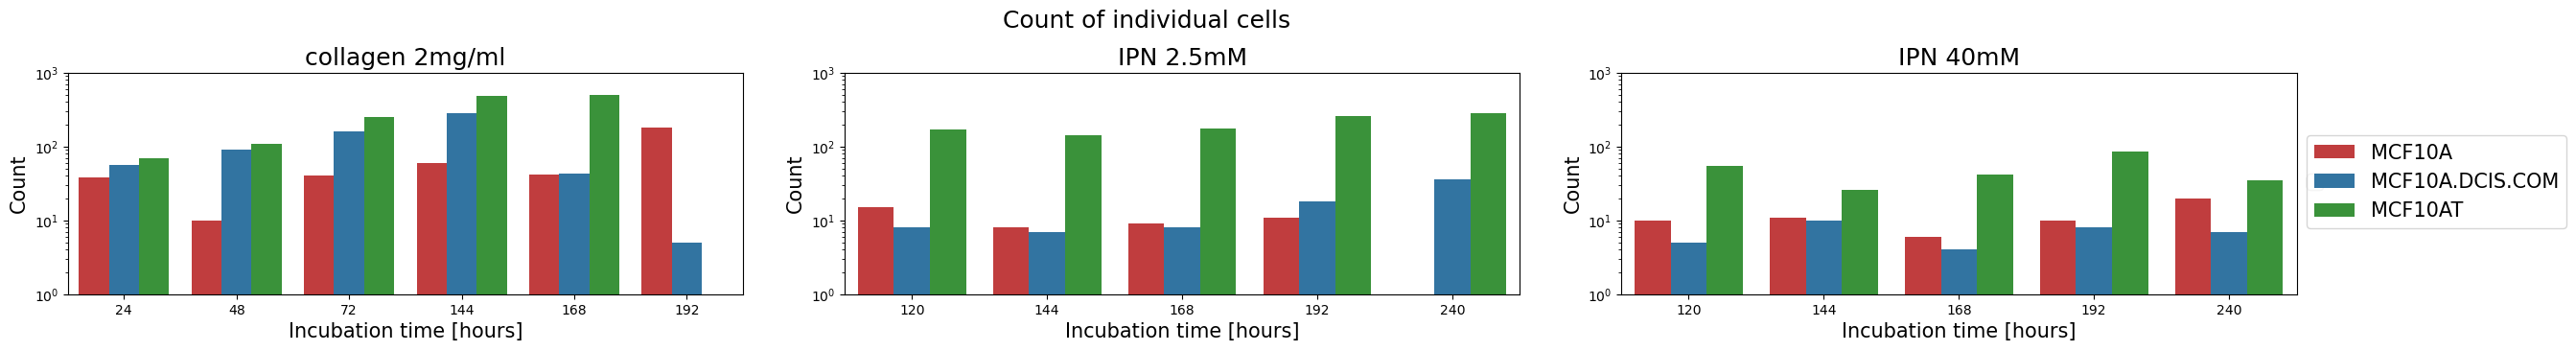

In [58]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Count of individual cells", fontsize=18, y=1.1)
#fig.legend(loc=7)



for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    ax=axs[i]

    #mymodel = np.poly1d(np.polyfit(specific_specific_df_small['incubation_time'], specific_specific_df_small['area'], 1))
    #myline = np.linspace(specific_specific_df_small['incubation_time'].min(), specific_specific_df_small['incubation_time'].max(), 100)

    sns.countplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax) #smoothened by adjusting bandwidth
    #sns.histplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax) #smoothened by adjusting bandwidth

    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Count', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(1,1000)
    ax.get_legend().set_visible(False)


    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)

plt.savefig(path +'/plots/Individual_cells_count_timeseries.png',dpi=300)


['n: 38', 'n: 56', 'n: 70', 'n: 10', 'n: 92', 'n: 110', 'n: 40', 'n: 161', 'n: 252', 'n: 60', 'n: 283', 'n: 486', 'n: 42', 'n: 43', 'n: 501', 'n: 179', 'n: 5']
['n: 15', 'n: 8', 'n: 171', 'n: 8', 'n: 7', 'n: 142', 'n: 9', 'n: 8', 'n: 174', 'n: 11', 'n: 18', 'n: 258', 'n: 1', 'n: 36', 'n: 281']
['n: 10', 'n: 5', 'n: 54', 'n: 11', 'n: 10', 'n: 26', 'n: 6', 'n: 4', 'n: 42', 'n: 10', 'n: 8', 'n: 86', 'n: 20', 'n: 7', 'n: 35']


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1/plots/aspect_ratio_individual_cells.png'

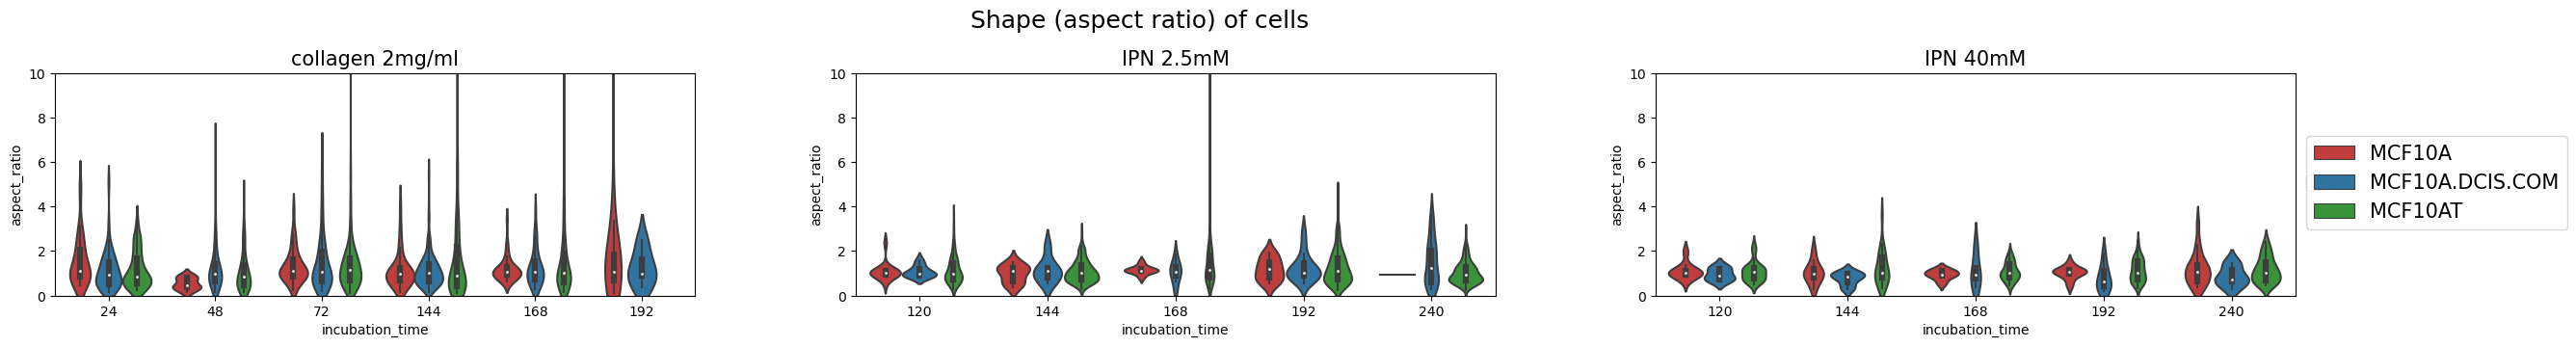

In [59]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Shape (aspect ratio) of cells", fontsize=18, y=1.1)


color=['red','blue','green']

for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    ax=axs[i]

    #mymodel = np.poly1d(np.polyfit(specific_specific_df_small['incubation_time'], specific_specific_df_small['area'], 1))
    #myline = np.linspace(specific_specific_df_small['incubation_time'].min(), specific_specific_df_small['incubation_time'].max(), 100)

    sns.violinplot(specific_df_small, x="incubation_time",y='aspect_ratio', hue="cell_line", palette=palette, ax=ax,)

    #ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
    #ax.set_yscale('log')
    #ax.set_ylabel('Area', fontsize= 12)  
    ax.set_title(f'{unique_material}', fontsize= 15)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(0,10)
    nobs = specific_df_small.groupby(['incubation_time', 'cell_line']).size()
    nobs = [str(x) for x in nobs]  #converts array into list and then to strings
    nobs = ["n: " + i for i in nobs] #adds n in front
    print(nobs)
    #pos = range(len(nobs))
    #for tick, label in zip(pos, ax.get_xticklabels()):
    #    ax.text(pos[tick], 5, nobs[tick],
    #        horizontalalignment='center',
    #        size='small',
    #        color='black')
    ax.get_legend().set_visible(False)
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)


plt.savefig(path +'/plots/aspect_ratio_individual_cells.png',dpi=300)


Convexity of spheroids & fit

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles/Exp1/plots/Convexity_time_series.png'

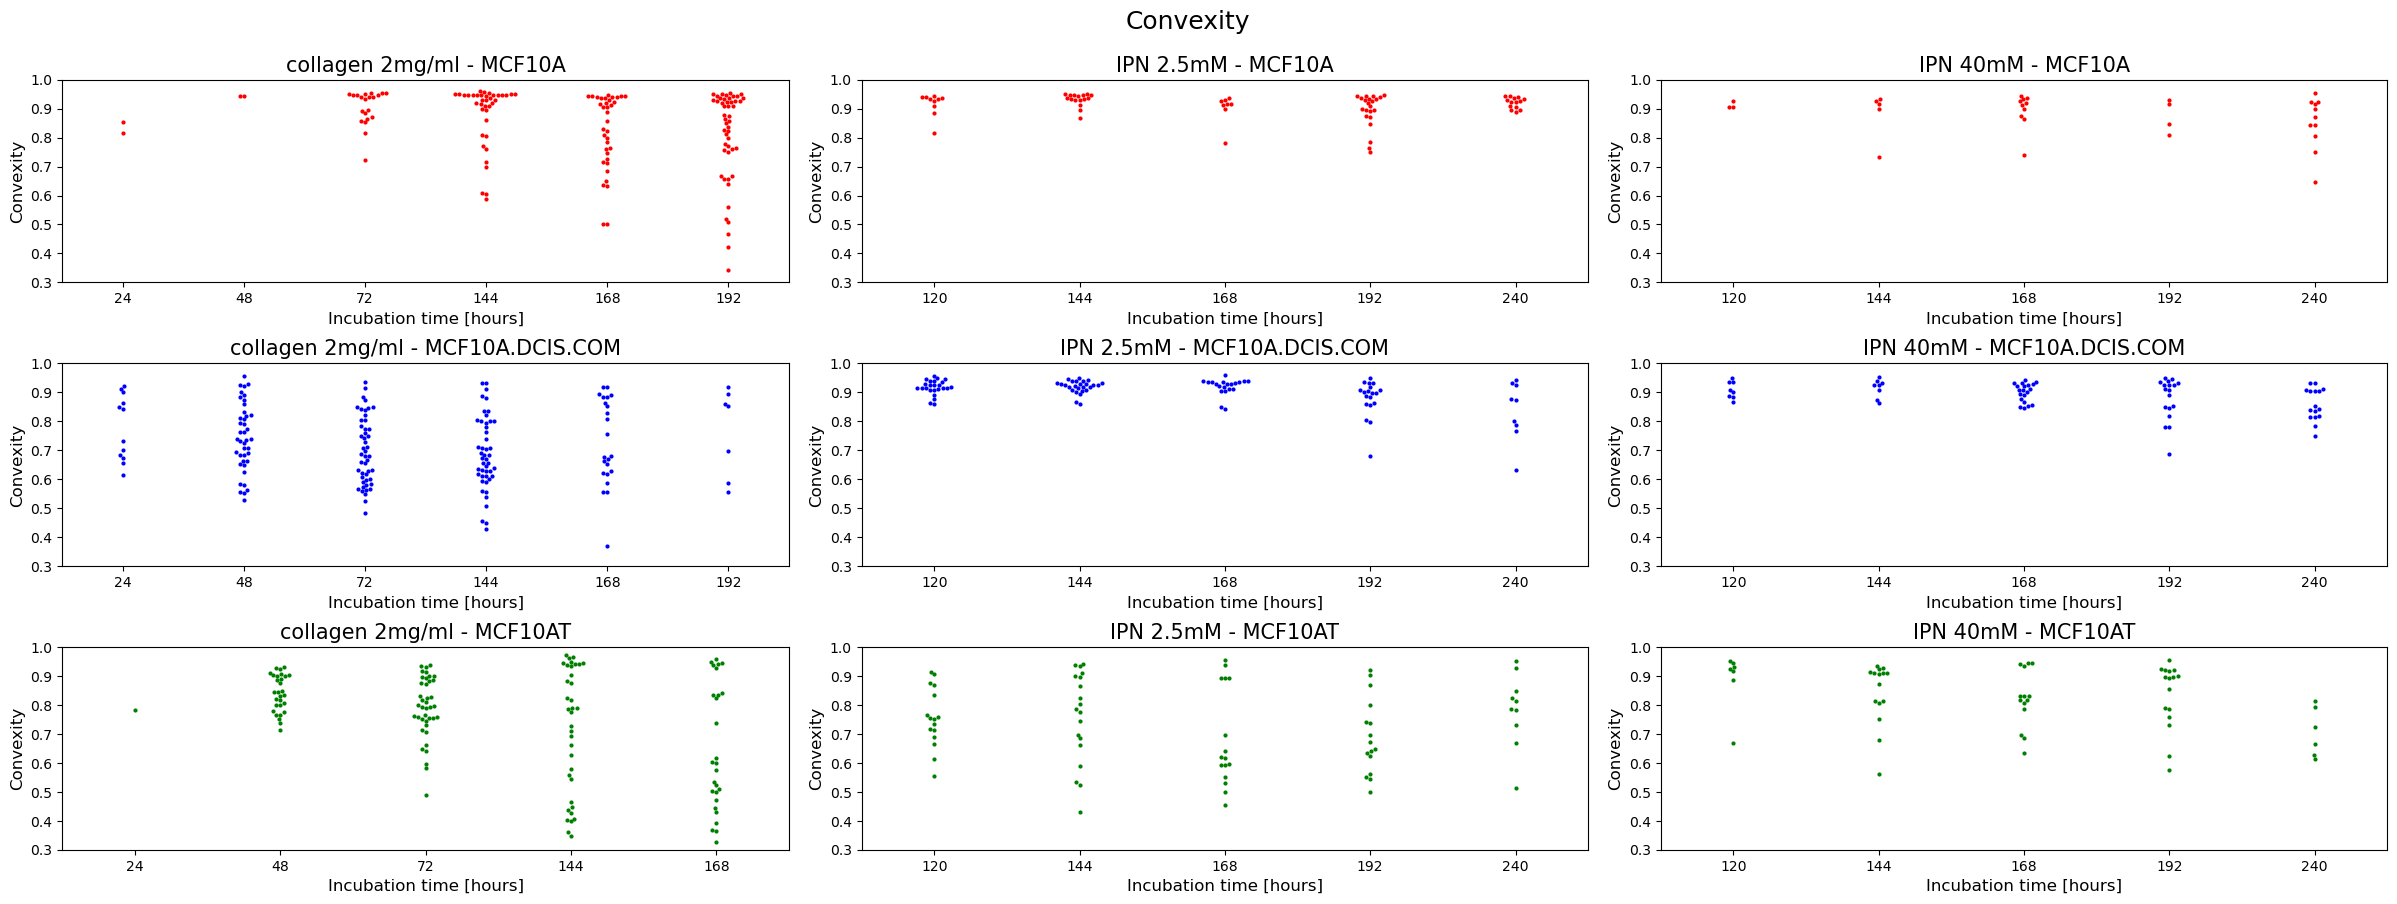

In [60]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle("Convexity", fontsize=18, y=0.95)
color=['red','blue','green']


for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]
        ax=axs[j,i]

        sns.swarmplot(data=specific_specific_df_big, y='convexity_perimeter', x='incubation_time', size=3, color=color[j], ax=ax)

        ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
        #ax.set_yscale('log')
        ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 15)
        ax.set_ylim(0.3,1)

plt.savefig(path +'/plots/Convexity_time_series.png',dpi=300)


fig, axs = plt.subplots(1,len(unique_materials),figsize=(30,3.3))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Fit of convexity", fontsize=18, y=1.05)

color=['red','blue','green']

for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]

        #fitting model - determining weights 𝑏₀ and 𝑏₁
        mymodel = np.poly1d(np.polyfit(specific_specific_df_big['incubation_time'], specific_specific_df_big['convexity_perimeter'], 1))
        myline = np.linspace(specific_specific_df_big['incubation_time'].min(), specific_specific_df_big['incubation_time'].max(), 100)

        # Plot the polynomial fit
        # Plot the swarm plot
        ax=axs[i]
        ax.plot(myline, mymodel(myline), color= color[j])

        ax.set_xlabel('Incubation time [hours]', fontsize= 10)  
        #ax.set_yscale('log')
        #ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material}', fontsize= 12)
        #ax.set_ylim(1000,10000000)
        ax.set_ylim(0.6,1)


plt.savefig(path +'/plots/Convexity_fit.png',dpi=300)


MCF10T: Segmented images & contour area

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10AT 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10AT 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


10A

In [ ]:

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10A 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10A 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


DCIS.COM

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('DCIS.COM 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('DCIS.COM 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Time-series histograms", fontsize=18, y=1)

timestamp = 140

for i,unique_material in enumerate(unique_materials):
    specific_df = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 1500) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]
        ax=axs[j,i]
        sns.scatterplot(specific_specific_df, y='area', ax=ax, x='incubation_time')
        ax.set_yscale('log')
        ax.set_xlabel('Incubation')  
        ax.set_ylabel('Area')
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_ylim(100,10000000)


In [ ]:
columns_to_plot=['cell_line','incubation_time','material','area_N','perimeter_N','roundness_N','aspect_ratio_N']
plot= final_df_with_normalized[columns_to_plot]

grouped_material = plot.groupby('material')

first_displayed = False
for name_material, material in grouped_material:
    #print(name_material)
    grouped_cell_line = material.groupby('cell_line')
    fig, ax = plt.subplots()
    
    for cell_line_name, line in grouped_cell_line:
        #print(cell_line_name)
        grouped = line.groupby('incubation_time').mean()
        #plt.plot(grouped['incubation_time'],grouped['area_N'],marker='o', linestyle='-', label=f'Group {cell_line_name}' )
        print(grouped)


In [ ]:
fig, ax = plt.subplots()
for name, group in grouped:
    ax.plot(group['area_N'], group['incubation_time'], marker='o', linestyle='-', label=f'Group {name}')


In [ ]:

grouped = plot.groupby(['material'])
grp = plot.groupby(['material', 'concentration','incubation_time'])

for (concentration), group in grouped:
    rows =  2
    columns = 7
    for (material,concentration, incubation_time), group in grp:
        for a in range(rows):
            for b in range(columns):
                    print(a,b)

In [ ]:

concentration_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM'
}
material_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM' 
}
materials_no = plot['material'].nunique()

#for (material, concentration), group1 in grp:
#   times = group1['incubation_time'].nunique()
for (concentration), group in grouped:
    rows_unique =  group['incubation_time'].nunique()
    for (material,concentration, incubation_time), group in grp:
        cols = 4
        rows = rows_unique
    # Calculate the number of rows needed
        fig, axes= plt.subplots(rows, cols,figsize=(15, 4), sharey=True)
        fig.suptitle(f'{concentration_mapping1.get(concentration)}, {incubation_time} hours', fontsize=16)
        for a in range(rows):
            for b in range(cols):
                for column in group.columns:
                    if column not in ['concentration','incubation_time', 'material','cell_line']:
                        sns.kdeplot(data=group[column],ax=axes[a,b], legend = False)
    #                    else:
    #                       sns.kdeplot(data=group[column],ax=axes[a,i+1], legend = False)
                    else:
                        continue

In [ ]:
for key, group in grouped_day:
    #plt.title("Incubation time" + str(key),loc='center')
    pairplot = sns.pairplot(group, kind='scatter', hue='cell_line', corner=True, vars=['material','concentration','area_N', 'perimeter_N', 'roundness_N','aspect_ratio_N'])
    pairplot.figure.suptitle(f'Incubation time: {key} hours, {concentration}', fontsize=20 )  # Adjust y position for title



